# Assignment 4a - Variational Auto-Encoders
## Deep Learning Course - Vrije Universiteit Amsterdam, 2022

#### Instructions on how to use this notebook:

This notebook is hosted on Google Colab. To be able to work on it, you have to create your own copy. Go to *File* and select *Save a copy in Drive*.

You can also avoid using Colab entirely, and download the notebook to run it on your own machine. If you choose this, go to *File* and select *Download .ipynb*.

The advantage of using Colab is that you can use a GPU. You can complete this assignment with a CPU, but it will take a bit longer. Furthermore, we encourage you to train using the GPU not only for faster training, but also to get experience with this setting. This includes moving models and tensors to the GPU and back. This experience is very valuable because for various models and large datasets (like large CNNs for ImageNet, or Transformer models trained on Wikipedia), training on GPU is the only feasible way.

The default Colab runtime does not have a GPU. To change this, go to *Runtime - Change runtime type*, and select *GPU* as the hardware accelerator. The GPU that you get changes according to what resources are available at the time, and its memory can go from a 5GB, to around 18GB if you are lucky. If you are curious, you can run the following in a code cell to check:

```sh
!nvidia-smi
```

Note that despite the name, Google Colab does  not support collaborative work without issues. When two or more people edit the notebook concurrently, only one version will be saved. You can choose to do group programming with one person sharing the screen with the others, or make multiple copies of the notebook to work concurrently.

**Submission:** Upload your notebook in .ipynb format to Canvas. The code and answers to the questions in the notebook are sufficient, no separate report is expected. 

In [86]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


## Introduction

In this assignment, we are going to implement a Variational Auto-Encoder (VAE). A VAE is a likelihood-based deep generative model that consists of a stochastic encoder (a variational posterior over latent variables), a stochastic decoder, and a marginal distribution over latent variables (a.k.a. a prior). The model was originally proposed in two concurrent papers:
- [Kingma, D. P., & Welling, M. (2013). Auto-encoding variational bayes. arXiv preprint arXiv:1312.6114.](https://arxiv.org/abs/1312.6114)
- [Rezende, Danilo Jimenez, Shakir Mohamed, and Daan Wierstra. "Stochastic backpropagation and approximate inference in deep generative models." International conference on machine learning. PMLR, 2014.](https://proceedings.mlr.press/v32/rezende14.html)

You can read more about VAEs in Chapter 4 of the following book:
- [Tomczak, J.M., "Deep Generative Modeling", Springer, 2022](https://link.springer.com/book/10.1007/978-3-030-93158-2)

In particular, the goals of this assignment are the following:

- Understand how VAEs are formulated
- Implement components of VAEs using PyTorch
- Train and evaluate a model for image data

### Theory behind VAEs

VAEs are latent variable models trained with variational inference. In general, the latent variable models define the following generative process:
\begin{align}
1.\ & \mathbf{z} \sim p_{\lambda}(\mathbf{z}) \\
2.\ & \mathbf{x} \sim p_{\theta}(\mathbf{x}|\mathbf{z})
\end{align}

In plain words, we assume that for observable data $\mathbf{x}$, there are some latent (hidden) factors $\mathbf{z}$. Then, the training objective is log-likelihood function of the following form:
$$
\log p_{\vartheta}(\mathbf{x})=\log \int p_\theta(\mathbf{x} \mid \mathbf{z}) p_\lambda(\mathbf{z}) \mathrm{d} \mathbf{z} .
$$

The problem here is the intractability of the integral if the dependencies between random variables $\mathbf{x}$ and $\mathbf{z}$ are non-linear and/or the distributions are non-Gaussian.

By introducing variational posteriors $q_{\phi}(\mathbf{z}|\mathbf{x})$, we get the following lower bound (the Evidence Lower Bound, ELBO):
$$
\log p_{\vartheta}(\mathbf{x}) \geq \mathbb{E}_{\mathbf{z} \sim q_\phi(\mathbf{z} \mid \mathbf{x})}\left[\log p_\theta(\mathbf{x} \mid \mathbf{z})\right]-\mathrm{KL}\left(q_\phi(\mathbf{z} \mid \mathbf{x}) \| p_\lambda(\mathbf{z})\right) .
$$

Note that we want to *maximize* this objective, therefore, in the code you are going to have to implement NELBO (negative ELBO) as a loss function (i.e., a minimization task). 

## IMPORTS

In [87]:
# DO NOT REMOVE!
import os

import numpy as np
import matplotlib.pyplot as plt

import torch

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision.datasets import MNIST

In [88]:
# Check if GPU is available and determine the device
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

print(f'The available device is {device}')

The available device is cpu


In [89]:
# # mount drive: WE NEED IT FOR SAVING IMAGES!
# from google.colab import drive
# drive.mount('/content/gdrive')

In [90]:
# PLEASE CHANGE IT TO YOUR OWN GOOGLE DRIVE!
images_dir = './files/'

## Auxiliary functions

Let us define some useful log-distributions:

In [91]:
# DO NOT REMOVE
PI = torch.from_numpy(np.asarray(np.pi))
EPS = 1.e-5


def log_categorical(x, p, num_classes=256, reduction=None, dim=None):
    x_one_hot = F.one_hot(x.long(), num_classes=num_classes)
    log_p = x_one_hot * torch.log(torch.clamp(p, EPS, 1. - EPS))
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p


def log_bernoulli(x, p, reduction=None, dim=None):
    pp = torch.clamp(p, EPS, 1. - EPS)
    log_p = x * torch.log(pp) + (1. - x) * torch.log(1. - pp)
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p


def log_normal_diag(x, mu, log_var, reduction=None, dim=None):
    D = x.shape[1]
    log_p = -0.5 * D * torch.log(2. * PI) - 0.5 * log_var - 0.5 * torch.exp(-log_var) * (x - mu)**2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p


def log_standard_normal(x, reduction=None, dim=None):
    D = x.shape[1]
    log_p = -0.5 * D * torch.log(2. * PI) - 0.5 * x**2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

## Implementing VAEs

The goal of this assignment is to implement four classes:
- `Encoder`: this class implements the encoder (variational posterior), $q_{\phi}(\mathbf{z}|\mathbf{x})$.
- `Decoder`: this class implements the decoded (the conditional likelihood), $p_{\theta}(\mathbf{x}|\mathbf{z})$.
- `Prior`: this class implements the marginal over latents (the prior), $p_{\lambda}(\mathbf{z})$.
- `VAE`: this class combines all components.

#### Question 0: (3 pt) 
**Fully-connected Neural Networks (MLPs) or Convolutional Neural Networks**

This is not a real question but rather a comment. You are asked to implement your VAE using fully connected neural networks (MLPs) or convolutional neural networks (ConvNets). 

There is a difference in grading of this assignment based on your decision:
- **If you decide to implement your VAE with MLPs and the model works properly, you get 1 pt.**
- **If you decide to implement your VAE with ConvNets and the model works properly, you get 3 pts.**

### Encoder
We start with `Encoder`. Please remember that we assume the Gaussian variational posterior with a diagonal covariance matrix.

Feel free to add other methods to the class as well as arguments to the class initialization.

In [92]:
# YOUR CODE GOES HERE
# NOTE: The class must containt the following functions: 
# (i) reparameterization
# (ii) sample
# Moreover, forward must return the log-probability of variational posterior for given x, i.e., log q(z|x)

class Encoder(nn.Module):
    def __init__(self, h_dim, latent_dim):
        super(Encoder, self).__init__()

        self.latent_dim = latent_dim

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding =1)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=7, padding = 0)

        self.fc1 = nn.Linear(16, h_dim)
        self.fc_mu = nn.Linear(h_dim, latent_dim)
        self.fc_log_var = nn.Linear(h_dim, latent_dim)



    @staticmethod
    def reparameterization(mu, log_var):
        # Use 0.5 because variance is the square of std
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
        

    def sample(self, x=None, mu_e=None, log_var_e=None):
        """
        Sample from the encoder. 
        If x is given (not equal to None), then copmute variational posterior distribution q(z|x) and sample from it.
        Otherwise, use `mu_e` and `log_var_e` as parameter of the variational posterior and sample from it.

        x: torch.tensor, with dimensionality (mini-batch, x_dim)
             a mini-batch of data points
        mu_e: torch.tensor, with dimensionality (mini-batch, x_dim)
             mean vector of the variational posterior
        log_var_e: torch.tensor, with dimensionality (mini-batch, x_dim)
             log variance of the variational posterior
        return: z: torch.tensor, with dimensionality (mini-batch, z_dim)
        """
        pass

    def forward(self, x):
        """
        Compute log-probability of variational posterior for given x, i.e., log q(z|x)
        x: torch.tensor, with dimensionality (mini-batch, x_dim)
             a mini-batch of data points
        """
        pass

    @staticmethod
    def reparameterization(mu_e, log_var_e):
        std = torch.exp(0.5*log_var_e)
        eps = torch.randn_like(std)
        z = mu_e + (eps * std)
        return z

    def forward(self, x):
        h = F.relu(self.conv1(x))
        h = F.max_pool2d(h, 2, stride=2)
        h = F.relu(self.conv2(h))
        h = F.max_pool2d(h, 2, stride=2)
        h = F.relu(self.conv3(h))
        h = h.view(h.size(0), -1)
        #print(h.shape)
        h = self.fc1(h)

        mu = self.fc_mu(h)
        log_var = self.fc_log_var(h)


        z = self.reparameterization(mu, log_var)
        return z, mu, log_var
        


Please answer the following questions:


#### Question 1 (0.5 pt)

Please explain the reparameterization trick and provide a mathematical formula.

For backpropagation/gradient descent, random sampling from the distribution defined by the decoder, makes this very difficult. The parametrization trick introduces a gaussian normal and multiplies this with the std deviation as another form of sampling. This allows for differentiation of mu and std w.r.t the loss and thus allows for backpropagation/grad descent.

`TODO` math formula for reparametrization trick

#### Question 2 (0.25 pt)

Please write down mathematically the log-probability of the encoder (variational posterior).

`TODO` Is this simply the distribution we will sample z from with the variable mu & std filled in??

### Decoder

The decoder is the conditional likelihood, i.e., $p(\mathbf{x}|\mathbf{z})$. Please remember that we must decide on the form of the distribution (e.g., Bernoulli, Gaussian, Categorical). Please discuss it with a TA or a lecturer if you are in doubt.

In [110]:
# YOUR CODE GOES HERE
# NOTE: The class must containt the following function: 
# (i) sample
# Moreover, forward must return the log-probability of the conditional likelihood function for given z, i.e., log p(x|z)

class Decoder(nn.Module):
    def __init__(self,latent_dim, h_dim):
        super(Decoder, self).__init__()
        self.device = device
        self.latent_dim = latent_dim
        self.h_dim = h_dim

        self.fc1 = nn.Linear(latent_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, 16)
        self.deconv1 = nn.ConvTranspose2d(16, 16, kernel_size=7, padding=0)
        self.deconv2 = nn.ConvTranspose2d(16, 16, kernel_size=3, padding=1)
        self.deconv3 = nn.ConvTranspose2d(16, 1, kernel_size=3, padding=1)

    def sample(self, z):
        """
        For a given latent code compute parameters of the conditional likelihood 
        and sample x ~ p(x|z)

        z: torch.tensor, with dimensionality (mini-batch, z_dim)

        return:
        x: torch.tensor, with dimensionality (mini-batch, x_dim)
        """
        pass

    def forward(self, z, x=None):
        """
        Compute the log probability: log p(x|z). 
        z: torch.tensor, with dimensionality (mini-batch, z_dim)
        x: torch.tensor, with dimensionality (mini-batch, x_dim)
        """
        h = self.fc1(z)
        h = self.fc2(h)
        h = h.view(-1, 16, 1, 1)
        
        # How to double the size of the image with max unpooling?
        h = F.relu(F.upsample(self.deconv1(h), scale_factor=2))
        h = F.relu(F.upsample(self.deconv2(h), scale_factor=2))
        x_hat = torch.sigmoid(self.deconv3(h))
        return x_hat
        

Please answer the following questions:

#### Question 3 (0.5 pt)

Please explain your choice of the distribution for image data used in this assignment. Additionally, please write it down mathematically (if you think that presenting it as the log-probability, then please do it).

ANSWER: [Please fill in]
`todo` Bernoulli because pixels are either 1/0

#### Question 4 (0.5 pt)

Please explain how one can sample from the distribution chosen by you. Please be specific and formal (i.e., provide mathematical formulae). If applicable, please provide a code snippet.

### Prior

The prior is the marginal distribution over latent variables, i.e., $p(\mathbf{z})$. It plays a crucial role in the generative process and also in synthesizing images of a better quality.

In this assignment, you are asked to implement a prior that is learnable (e.g., parameterized by neural networks). If you decide to implement the standard Gaussian prior only, then please be aware that you will not get any points.


For the learnable prior you can choose one of the following options:


*   Mixture of Gaussians
*   Normalizing Flow


In [ ]:
# YOUR CODE GOES HERE
# NOTES:
# (i) Implementing the standard Gaussian prior does not give you any points!
# (ii) The function "sample" must be implemented.
# (iii) The function "forward" must return the log-probability, i.e., log p(z)

class Prior(nn.Module):
    def __init__(self, device='cpu'):
        super(Prior, self).__init__()
        self.device = device

    def sample(self, batch_size):
        """
        Sample from the prior distribution p(z)
        batch_size: int, the number of samples to generate
        return: z: torch.tensor, with dimensionality (batch_size, z_dim)
        """
        pass     

    def forward(self, z):
        """
        Compute the log probability: log p(z). 
        z: torch.tensor, with dimensionality (mini-batch, z_dim)
        """
        pass

#### Question 5 (2 pts max)

**Option 1 (0 pt):  Standard Gaussian**

**NOTE: *If you decide to use the standard Gaussian prior, please indicate it in your answer. However, you will get 0 pt for this question.***

**Option 2 (0.5 pt): Mixture of Gaussains**

Please do the following:
- (0.25 pt) Please explain your prior and write it down mathematically
- (0.15 pt) Please write down its sampling procedure (if necessary, please add a code snippet).
- (0.1 pt) Please write down its log-probability (a mathematical formula).

**Option 3 (2 pts): Normalizing Flow**

Please do the following:
- (1 pt) Please explain your prior and write it down mathematically
- (0.5 pt) Please write down its sampling procedure (if necessary, please add a code snippet).
- (0.5 pt) Please write down its log-probability (a mathematical formula).

### Complete VAE

The last class is `VAE` tha combines all components. Please remember that this class must implement the **Negative ELBO** in `forward`, as well as `sample` (*hint*: it is a composition of `sample` functions from the prior and the decoder).

In [ ]:
# YOUR CODE GOES HERE
# This class combines Encoder, Decoder and Prior.
# NOTES:
# (i) The function "sample" must be implemented.
# (ii) The function "forward" must return the negative ELBO. Please remember to add an argument "reduction" that is either "mean" or "sum".
class VAE(nn.Module):
    def __init__(self, device='cpu'):
        super(VAE, self).__init__()
        self.encoder = Encoder(h_dim=200, latent_dim=20)
        self.decoder = Decoder(latent_dim=20, h_dim=200)
        self.prior = Prior()


    def sample(self, batch_size=64):
        # Generate the amount of images equal to batch size and return them as a batch of tensors
        samples = []
        for i in range(batch_size):
            z = self.encoder.reparameterization(self.mu, self.log_var)
            x_hat = self.decoder.forward(z)
            samples.append(x_hat)
            
        return torch.cat(samples)

    def forward(self, x, reduction='mean'):
        z, mu, log_var = self.encoder.forward(x)
        x_hat = self.decoder.forward(z)
        self.mu = mu
        self.log_var = log_var  


        RE = F.binary_cross_entropy(x_hat, x, reduction='sum')
        KLD = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        NELBO = RE + KLD

        # Compute the negative ELBO
        # NELBO = -log_p_x_z + log_q_z_x - log_p_z

        # # Negative ELBO (NELBO)
        # NELBO = 0.

        if reduction == 'sum':
            return NELBO.sum()
        else:
            return NELBO.mean()

/var/folders/97/50twy7395gs8j3ss631vmvvw0000gp/T/ipykernel_9062/1697300136.py:42: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  h = F.relu(F.upsample(self.deconv1(h), scale_factor=2))
/var/folders/97/50twy7395gs8j3ss631vmvvw0000gp/T/ipykernel_9062/1697300136.py:43: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  h = F.relu(F.upsample(self.deconv2(h), scale_factor=2))


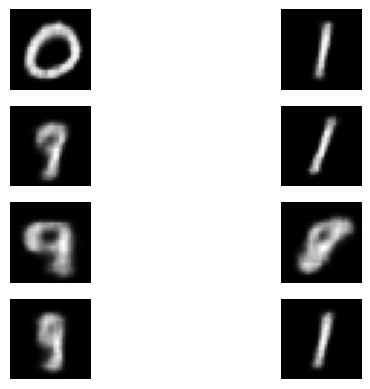

In [ ]:
# # Perform one forward pass
# model = VAE()
# model.to(device)

# transforms_train = torchvision.transforms.Compose([
#     torchvision.transforms.ToTensor()
# ])

# dataset = MNIST('./files/', train=True, download=True,
#                       transform=transforms_train
# )

# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [50000, 10000], generator=torch.Generator().manual_seed(14))

# #-dataloaders
# batch_size = 32

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# model.train()

# for epoch in range(1):
#     for indx_batch, (batch, _) in enumerate(train_loader):
#         batch = batch.to(device)

#         loss = model.forward(batch, reduction='mean')

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

# num_x =4
# num_y = 2
# x = model.sample(num_x * num_y)
# x = x.to('cpu').detach().numpy()
# shape = (28, 28)

# fig, ax = plt.subplots(num_x, num_y)
# for i, ax in enumerate(ax.flatten()):
#     plottable_image = np.reshape(x[i], shape)
#     ax.imshow(plottable_image, cmap='gray')
#     ax.axis('off')

    



#### Question 6 (0.5 pt)

Please write down mathematically the **Negative ELBO** and provide a code snippet.

ANSWER: [Please fill in]

### Evaluation and training functions

**Please do not remove or modify them.**

In [123]:
# DO NOT REMOVE

def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # EVALUATION
    if model_best is None:
        # load best performing model
        model_best = torch.load(name + '.model')

    model_best.eval()
    loss = 0.
    N = 0.
    for indx_batch, (test_batch, _) in enumerate(test_loader):
        test_batch = test_batch.to(device)
        loss_t = model_best.forward(test_batch, reduction='sum')
        loss = loss + loss_t.item()
        N = N + test_batch.shape[0]
    loss = loss / N

    if epoch is None:
        print(f'FINAL LOSS: nll={loss}')
    else:
        print(f'Epoch: {epoch}, val nll={loss}')

    return loss


def samples_real(name, test_loader, shape=(28,28)):
    # real images-------
    num_x = 4
    num_y = 4
    x, _ = next(iter(test_loader))
    x = x.to('cpu').detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], shape)
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name+'_real_images.pdf', bbox_inches='tight')
    plt.close()


def samples_generated(name, data_loader, shape=(28,28), extra_name=''):
    x, _ = next(iter(data_loader))
    x = x.to('cpu').detach().numpy()

    # generations-------
    model_best = torch.load(name + '.model')
    model_best.eval()

    num_x = 4
    num_y = 4
    x = model_best.sample(num_x * num_y)
    x = x.to('cpu').detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], shape)
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name + '_generated_images' + extra_name + '.pdf', bbox_inches='tight')
    plt.close()


def plot_curve(name, nll_val):
    plt.plot(np.arange(len(nll_val)), nll_val, linewidth='3')
    plt.xlabel('epochs')
    plt.ylabel('nll')
    plt.savefig(name + '_nll_val_curve.pdf', bbox_inches='tight')
    plt.close()

In [124]:
# DO NOT REMOVE

def training(name, max_patience, num_epochs, model, optimizer, training_loader, val_loader, shape=(28,28)):
    nll_val = []
    best_nll = 1000.
    patience = 0

    # Main loop
    for e in range(num_epochs):
        # TRAINING
        model.train()
        for indx_batch, (batch, _) in enumerate(training_loader):
            batch = batch.to(device)
            loss = model.forward(batch, reduction='mean')

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation
        loss_val = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_val)  # save for plotting

        if e == 0:
            print('saved!')
            torch.save(model, name + '.model')
            best_nll = loss_val
        else:
            if loss_val < best_nll:
                print('saved!')
                torch.save(model, name + '.model')
                best_nll = loss_val
                patience = 0

                samples_generated(name, val_loader, shape=shape, extra_name="_epoch_" + str(e))
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    nll_val = np.asarray(nll_val)

    return nll_val

### Setup

**NOTE: *Please comment your code! Especially if you introduce any new variables (e.g., hyperparameters).***

In the following cells, we define `transforms` for the dataset. Next, we initialize the data, a directory for results and some fixed hyperparameters.

In [125]:
# PLEASE DEFINE APPROPRIATE TRANFORMS FOR THE DATASET
# Transform MNIST data to tensor and normalize it to [-1, 1]
transforms_train = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

transforms_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

Please do not modify the code in the next cell.

In [126]:
# DO NOT REMOVE
#-dataset
dataset = MNIST('./files/', train=True, download=True,
                      transform=transforms_train
                )

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [50000, 10000], generator=torch.Generator().manual_seed(14))

test_dataset = MNIST('./files/', train=False, download=True,
                      transform=transforms_test
                     )
#-dataloaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#-creating a dir for saving results
name = 'vae'
result_dir = './files/results/vae/' #images_dir + 'results/' + name + '/'
# if not(os.path.exists(result_dir)):
#     os.mkdir(result_dir)

#-hyperparams (please do not modify them for the final report)
num_epochs = 1000 # max. number of epochs
max_patience = 20 # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

In the next cell, please initialize the model. Please remember about commenting your code!

In [127]:
# YOUR CODE COMES HERE:
model = VAE()

Please initialize the optimizer

In [128]:
# PLEASE DEFINE YOUR OPTIMIZER
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#### Question 7 (0.5 pt)

Please explain the choice of the optimizer, and comment on the choice of the hyperparameters (e.g., the learing reate value).

ANSWER: [Please fill in]

### Training and final evaluation

In the following two cells, we run the training and the final evaluation.

In [129]:
# DO NOT REMOVE OR MODIFY
# Training procedure
nll_val = training(name=result_dir + name, max_patience=max_patience, 
                   num_epochs=num_epochs, model=model, optimizer=optimizer,
                   training_loader=train_loader, val_loader=val_loader,
                   shape=(28,28))

/var/folders/97/50twy7395gs8j3ss631vmvvw0000gp/T/ipykernel_9062/1697300136.py:42: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  h = F.relu(F.upsample(self.deconv1(h), scale_factor=2))
/var/folders/97/50twy7395gs8j3ss631vmvvw0000gp/T/ipykernel_9062/1697300136.py:43: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  h = F.relu(F.upsample(self.deconv2(h), scale_factor=2))


RuntimeError: all elements of target should be between 0 and 1

In [ ]:
# DO NOT REMOVE OR MODIFY
# Final evaluation
test_loss = evaluation(name=result_dir + name, test_loader=test_loader)
f = open(result_dir + name + '_test_loss.txt', "w")
f.write(str(test_loss))
f.close()

samples_real(result_dir + name, test_loader)
samples_generated(result_dir + name, test_loader, extra_name='_FINAL')

plot_curve(result_dir + name, nll_val)

### Results and discussion

After a successful training of your model, we would like to ask you to present your data and analyze it. Please answer the following questions.


#### Question 8 (1 pt)

Please select the real data, and the final generated data and include them in this report. Please comment on the following:
- (0.5 pt) Do you think the model was trained properly by looking at the generations? Please motivate your answer well.
- (0.5 pt) What are potential problems with evaluating a generative model by looking at generated data? How can we evalute generative models (ELBO or NLL do not count as an answer)?

ANSWER: [Please fill in]

#### Question 9 (1.25 pt)

Please include the plot of the negative ELBO. Please comment on the following:
- (0.25 pt) Is the training of your VAE stable or unstable? Why?
- (1 pt) What is the influence of the optimizer on your model? Do the hyperparameter values of the optimizer important and how do they influence the training? Motivate well your answer (e.g., run the script with more than one learning rate and present two plots here).

ANSWER: [Please fill in]

# Grading (10pt)

- Question 0: 3pt
- Question 1: 0.5pt 
- Question 2: 0.25pt 
- Question 3: 0.5pt 
- Question 4: 0.5pt 
- Question 5: 2pt 
- Question 6: 0.5pt
- Question 7: 0.5pt
- Question 8: 1pt
- Question 9: 1.25pt